In [497]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta



sns.set_style('darkgrid')
#ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Part 1 ‐ Exploratory data analysis

In [3]:
os.listdir()

['ultimate_data_science_challenge.pdf',
 'logins.json',
 'Untitled.ipynb',
 'ultimate_data_challenge.json',
 '.ipynb_checkpoints']

In [434]:
data = pd.read_json('logins.json')
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [430]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [435]:
#make sure the dates are sorted
data = data.set_index('login_time')
data_sorted = data.sort_index()
data_sorted=data_sorted.reset_index()
data_sorted

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37
...,...
93137,1970-04-13 18:48:52
93138,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93140,1970-04-13 18:54:23


In [442]:
data.index.min(),data.index.max()

(Timestamp('1970-01-01 20:12:16'), Timestamp('1970-04-13 18:57:38'))

In [443]:
data.isna().sum()

Series([], dtype: float64)

In [475]:
data_15_min = pd.DataFrame(data_sorted.resample('15Min',on='login_time').size(),columns=['count'])

data_15_min.head()
data_15_min.shape

(9788, 1)

In [457]:
len(data_15_min.index.strftime('%m'))

9788

Text(0, 0.5, 'number of user logins')

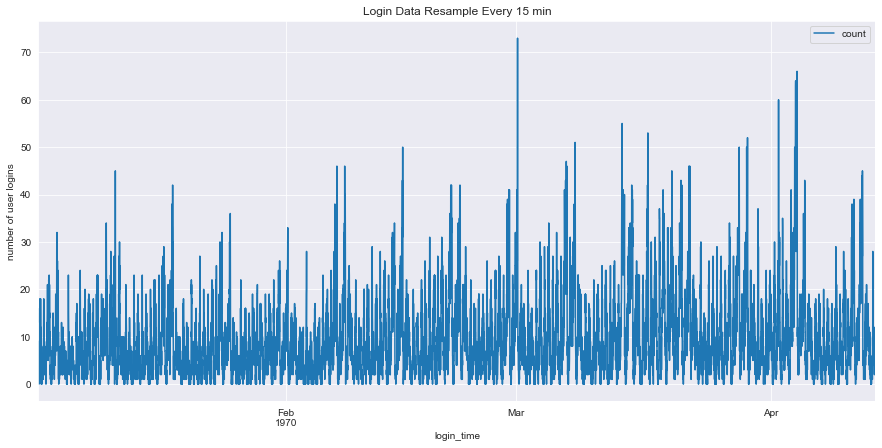

In [476]:

#Visualize
data_15_min.plot(figsize=(15,7))
plt.title('Login Data Resample Every 15 min')
plt.ylabel('number of user logins')
#plt.xticks(range(0,len(data_15_min.index),10),data_15_min.index.strftime('%d'));

There are many spikes in the data where logins increase, but generally logins are increasing closer to April, but I have to confirm with a lineplot.

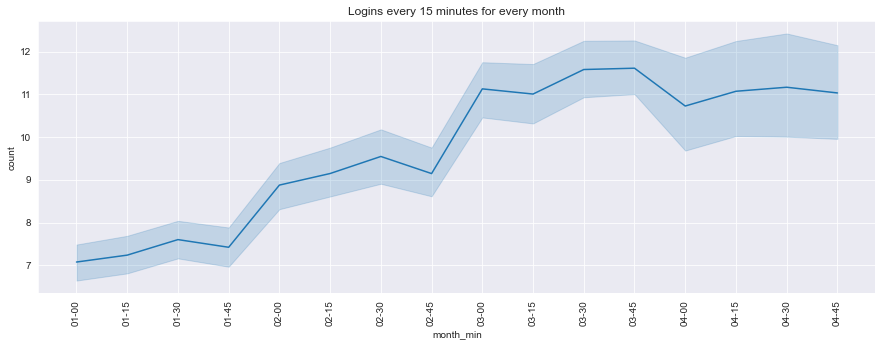

In [565]:
#plot same data in a lineplot
plt.figure(figsize=(15,5))
sns.lineplot(x='month_min',y='count', data = data_15_min)
plt.xticks(rotation=90)
plt.title('Logins every 15 minutes for every month');

This plot confirms that there is an increase in logins from month Jan to April.Next look at data monthly, daily and every 15 minutes

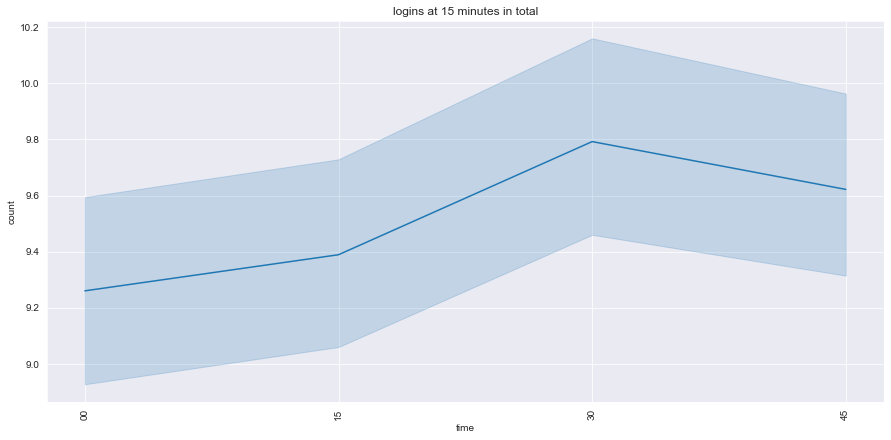

In [921]:
plt.figure(figsize=(15,7))

sns.lineplot(x='time',y='count', data = data_15_min)
plt.xticks(rotation=90)
plt.title('logins at 15 minutes in total');

In [495]:
#strip the minute, day and month and create columns for them to be able to group by them
data_15_min['time']=data_15_min.index.strftime('%M')
data_15_min['day'] = data_15_min.index.strftime('%d')
data_15_min['month'] = data_15_min.index.strftime('%m')

<AxesSubplot:xlabel='login_time'>

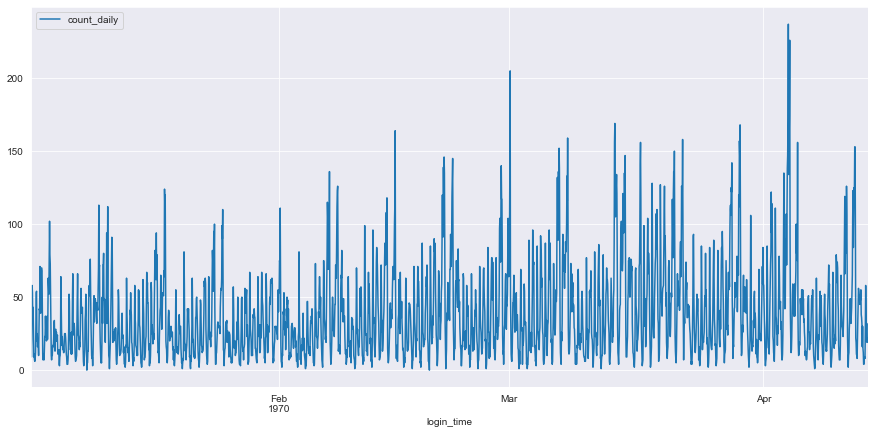

In [529]:
#data resampled hourly does not give additional informatio
data_hourly = pd.DataFrame(data_sorted.resample('h',on='login_time').size(),columns=['count_daily'])
data_hourly.plot(figsize=(15,7))

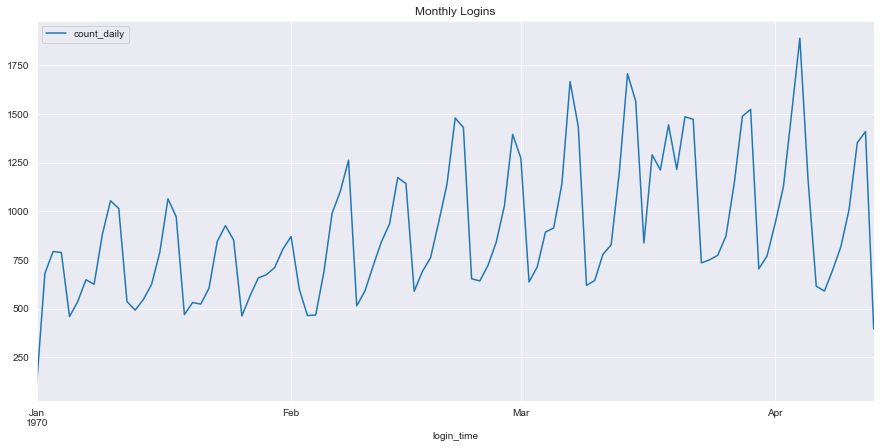

In [532]:
#sample daily
data_daily = pd.DataFrame(data_sorted.resample('d',on='login_time').size(),columns=['count_daily'])
data_daily.plot(figsize=(15,7))
plt.title('Monthly Logins');

There seems to be an upward trend from Jan to Apr but for each month logins seem to decrease at the end of the month. 

In [572]:
data_15_min.head()

,count,time,day,month,month_min
login_time,,,,,
1970-01-01 20:00:00,2,00,01,01,01-00
1970-01-01 20:15:00,6,15,01,01,01-15
1970-01-01 20:30:00,9,30,01,01,01-30
1970-01-01 20:45:00,7,45,01,01,01-45
1970-01-01 21:00:00,1,00,01,01,01-00


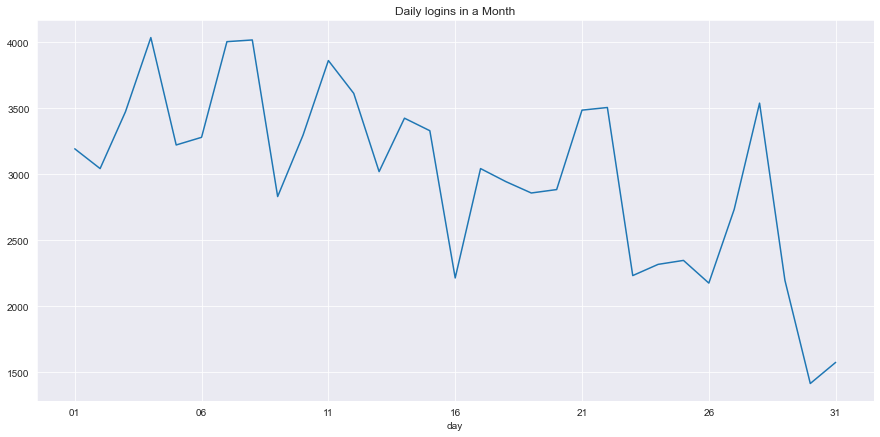

In [573]:
#trend logins in a month in total
data_15_min.groupby(['day'])['count'].sum().plot(figsize=(15,7))
plt.title('Daily logins in a Month');

plot confirms that there is a decrease in logins towards the end of the month. 

<AxesSubplot:xlabel='login_time'>

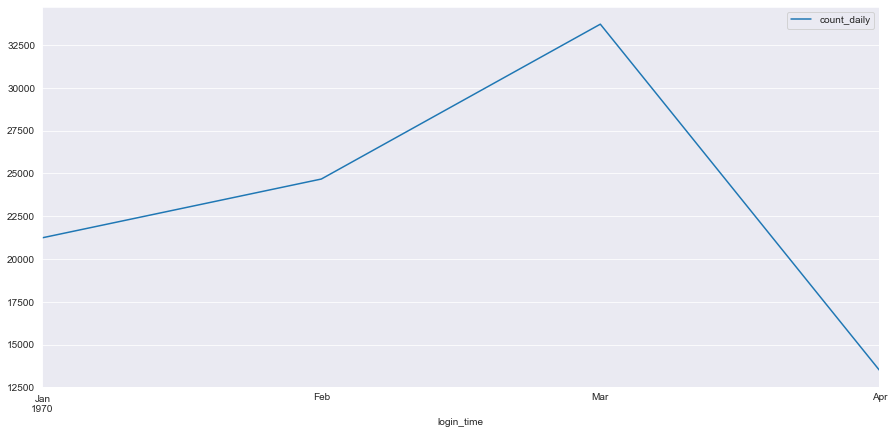

In [528]:
#sample monthly
data_daily = pd.DataFrame(data_sorted.resample('m',on='login_time').size(),columns=['count_daily'])
data_daily.plot(figsize=(15,7))

There is an increase in logins in the month of march which echoes the 15 minute resampled data graph on top

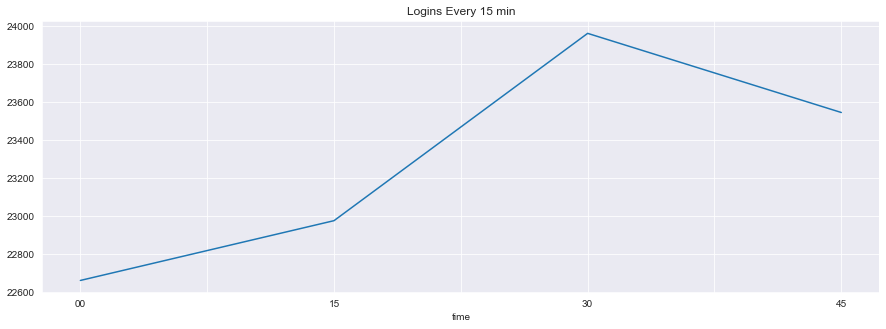

In [571]:
#logins every 15 minutes in total
data_15_min.groupby('time')['count'].sum().plot(figsize=(15,5))
plt.title('Logins Every 15 min');

There is a spike in logins at 30 minutes every hour

___


## Part 3 ‐ Predictive modeling

In [832]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix


In [133]:
ultimate_df = pd.read_json('ultimate_data_challenge.json')

In [135]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [136]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There is missing data for avg_rating of driver, phone, and avg_rating_by_driver

In [585]:
ultimate_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retention
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.692200
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.461588
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,1.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


In [574]:
#missing values
ultimate_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retention                    0
dtype: int64

no missing values for signup_date and last_trip_date

Ultimate wants to predict customer retention: then a new variable called retention is created. If trips_in_first_30_days does not equal 0 then retention = 1, else retention = 0 

In [584]:
#% of missing data
print('missing avg_rating_of_driver:{}%'.format(ultimate_df.avg_rating_of_driver.isna().sum() / ultimate_df.shape[0] * 100))
print('missing avg_rating_of_driver:{}%'.format(ultimate_df.avg_rating_by_driver.isna().sum()/ultimate_df.shape[0]*100))


missing avg_rating_of_driver:16.244%
missing avg_rating_of_driver:0.402%


16% avg_rating_of_driver is missing so this needs to be imputed whereas there is only 0.4% of avg_rating_of_driver is missing and this can be dropped 

In [577]:
#to make sure all the dates are in right format convert to datetime object
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df.signup_date)
ultimate_df['last_trip_date']=pd.to_datetime(ultimate_df.last_trip_date)


In [233]:
#calculate start date + 30 days
from datetime import datetime, timedelta
date_plus_30 = ultimate_df.signup_date+timedelta(30)




In [178]:
ultimate_df.signup_date.min(),ultimate_df.signup_date.max()

('2014-01-01', '2014-01-31')

In [179]:
ultimate_df.last_trip_date.min(),ultimate_df.last_trip_date.max()

('2014-01-01', '2014-07-01')

In [183]:
#add a retention column, 1 for retained customers and 0 for not retained
retention = np.where(ultimate_df.trips_in_first_30_days !=0,1,0)

ultimate_df['retention'] = retention

In [234]:
#making sure my df is correct
(ultimate_df.trips_in_first_30_days[ultimate_df.trips_in_first_30_days==0]!=ultimate_df.retention[ultimate_df.retention==0]).sum()

0

In [235]:
#fraction of retained users
print('percentage of retained customers= {}%.'.format((ultimate_df.retention==1).sum()/ultimate_df.shape[0]*100))
print('percentage of customers not retained= {}%.'.format((ultimate_df.retention==0).sum()/ultimate_df.shape[0]*100))

percentage of retained customers= 69.22%.
percentage of customers not retained= 30.78%.


Text(-0.01, 16000, 'not retained')

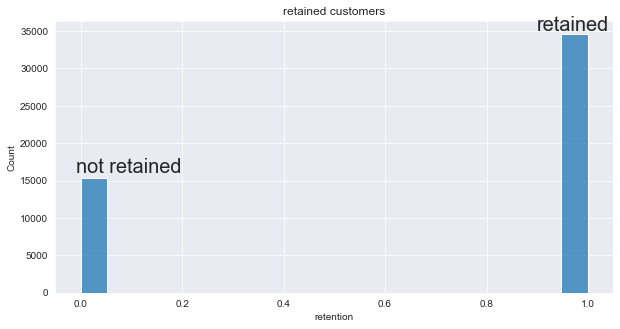

In [236]:
plt.figure(figsize=(10,5))
sns.histplot(ultimate_df.retention)
plt.title('retained customers')
labels ={1:'retained',0:'not retained'}
plt.text(0.9,35000,'retained',size=20)
plt.text(-0.01,16000,'not retained',size=20)
#plt.xticks(labels);

In [240]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


In [245]:
#checking if there are trips for not retained users, shoud be 0
ultimate_df.groupby('retention')['trips_in_first_30_days'].sum()

retention
0         0
1    113910
Name: trips_in_first_30_days, dtype: int64

In [588]:
#number of cities in the dataframe by retained cutomers
ultimate_df.groupby('retention')['city'].value_counts()/ultimate_df.shape[0] * 100


retention  city          
0          Winterfell        13.050
           Astapor           10.666
           King's Landing     7.064
1          Winterfell        33.622
           Astapor           22.402
           King's Landing    13.196
Name: city, dtype: float64

In [246]:
#how do retained customers comapare with not retained with using the ultimate black service
ultimate_df.groupby('retention')['ultimate_black_user'].sum()

retention
0     5379
1    13475
Name: ultimate_black_user, dtype: int64

In [297]:
#phones
pd.DataFrame(ultimate_df.groupby('retention')['phone'].value_counts())

phone
retention phone         
0         iPhone   10695
          Android   4617
1         iPhone   23887
          Android  10405

### Missing values

In [589]:
ultimate_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retention                    0
dtype: int64

In [594]:
#drop missing avg_rating_of_driver
df = ultimate_df[ultimate_df.avg_rating_by_driver.notna()]
df = df[df.phone.notna()]
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      7961
avg_surge                    0
last_trip_date               0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
retention                    0
dtype: int64

In [596]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49406 non-null  object        
 1   trips_in_first_30_days  49406 non-null  int64         
 2   signup_date             49406 non-null  datetime64[ns]
 3   avg_rating_of_driver    41445 non-null  float64       
 4   avg_surge               49406 non-null  float64       
 5   last_trip_date          49406 non-null  datetime64[ns]
 6   phone                   49406 non-null  object        
 7   surge_pct               49406 non-null  float64       
 8   ultimate_black_user     49406 non-null  bool          
 9   weekday_pct             49406 non-null  float64       
 10  avg_dist                49406 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
 12  retention               49406 non-null  int64 

In [601]:
#change ultimate_black_user to 0 and 1
df.ultimate_black_user = df.ultimate_black_user.astype('int')


In [611]:
#drop date columns and columns of type object so they can be hot encoded using pd.get_dummies
df = df.drop(['city','phone','signup_date','last_trip_date'], axis=1)
df.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retention'],
      dtype='object')

<AxesSubplot:>

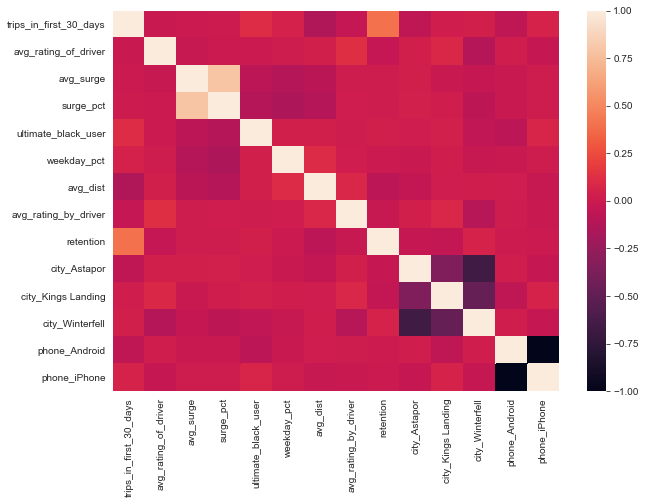

In [785]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr())

trips_in_30_days is positively correlated to retention

In [614]:
#get dummies for city and phone

dummy = pd.get_dummies(df[['city','phone']])
dummy.head()



,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,0,1,0,0,1
1,1,0,0,1,0
2,1,0,0,0,1
3,0,1,0,0,1
4,0,0,1,1,0


In [615]:
#concatinate dummy with df
df = pd.concat([df,dummy],axis=1)
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,1,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,1,0,0,1,1,0


In [620]:
df.rename(columns={"city_King's Landing":'city_Kings Landing'},inplace=True)
df.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retention', 'city_Astapor',
       'city_Kings Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone'],
      dtype='object')

In [621]:
#create X and y
X=df[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'city_Astapor',
       'city_Kings Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone']]
y = df['retention']

In [622]:
X.isna().sum()

trips_in_first_30_days       0
avg_rating_of_driver      7961
avg_surge                    0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
city_Astapor                 0
city_Kings Landing           0
city_Winterfell              0
phone_Android                0
phone_iPhone                 0
dtype: int64

In [629]:
#impute missing values in X
imputer = IterativeImputer()
imputer.fit(X)
X[:] = imputer.transform(X)

In [631]:
X.isna().sum()

trips_in_first_30_days    0
avg_rating_of_driver      0
avg_surge                 0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
city_Astapor              0
city_Kings Landing        0
city_Winterfell           0
phone_Android             0
phone_iPhone              0
dtype: int64

In [749]:
#if trips_in_first_30_days is left in the data there will be data leakage and I will get 100% accuracy so it needs to be removed
X_mod = X.drop('trips_in_first_30_days',axis=1)
X_mod.columns

Index(['avg_rating_of_driver', 'avg_surge', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'city_Astapor',
       'city_Kings Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone'],
      dtype='object')

In [750]:
#apply standard scaler to X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mod)
X_scaled

array([[ 0.17245546,  0.1148534 ,  0.3294733 , ..., -0.93419283,
        -0.65901667,  0.65901667],
       [ 0.70190526, -0.33762187, -0.44478651, ..., -0.93419283,
         1.51741231, -1.51741231],
       [-0.53347761, -0.33762187, -0.44478651, ..., -0.93419283,
        -0.65901667,  0.65901667],
       ...,
       [ 0.70190526, -0.33762187, -0.44478651, ...,  1.07044281,
         1.51741231, -1.51741231],
       [-2.82776008, -0.33762187, -0.44478651, ..., -0.93419283,
        -0.65901667,  0.65901667],
       [ 0.149322  , -0.33762187, -0.44478651, ..., -0.93419283,
         1.51741231, -1.51741231]])

In [751]:
#train, test sets
X_train,X_test, y_train,y_test=train_test_split(X_scaled,y,test_size=0.2, random_state=123)

In [752]:
X_train.shape,y_test.shape


((39524, 12), (9882,))

In [873]:
#run logistic regression with gridsearchcv
params = {'penalty':['l1','l2'],'C':np.logspace(-3,3,7)}#l1=lasso,l2=ridge
logreg = LogisticRegression()
logreg_gs = GridSearchCV(logreg,param_grid=params,cv=5)
logreg_gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [874]:
logreg_gs.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [875]:
#predict
y_pred_lr = logreg_gs.predict(X_test)

In [879]:
(y_test == 1).sum(), (y_test == 0).sum()

(6883, 2999)

Text(1, 2.2, 'Actual')

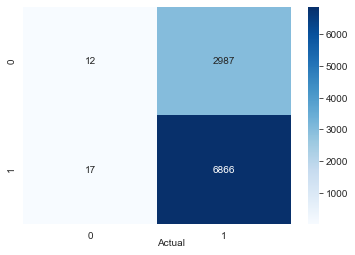

In [918]:
roc_auc_score(y_test,y_pred_lr)
confusion_matrix(y_test,y_pred_lr)
sns.heatmap(confusion_matrix(y_test,y_pred_lr), annot=True,cmap='Blues',fmt='g')
plt.text(1, 2.2, 'Actual')

In [877]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.41      0.00      0.01      2999
           1       0.70      1.00      0.82      6883

    accuracy                           0.70      9882
   macro avg       0.56      0.50      0.41      9882
weighted avg       0.61      0.70      0.57      9882



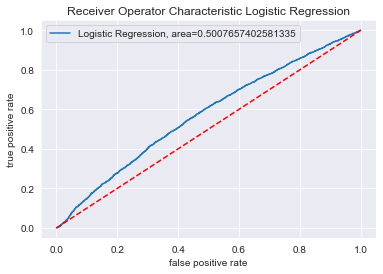

In [864]:
#ROC_curve
y_pred_proba= logreg_gs.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_lr)
fpr,tpr,threasholds = roc_curve(y_test,y_pred_proba)

plt.plot(fpr,tpr,label= 'Logistic Regression, area={}'.format(roc_auc_score(y_test,y_pred_lr)))
plt.plot([0,1],[0,1],'r--')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic Logistic Regression')
roc_auc_score(y_test,y_pred_proba)
plt.legend();

For this problem,it is more important that the positives and negatives found are actually positive and negatives, which is precision.
precision=41% and recall = 0, logistic regression is slightly better than a random classifier. In this data set I care about that when I predict a customer retained then it should be true, so I care about precision. So optimize for precision.Accuracy is the percentage of how many predictions our model got right, positive and negative, here it is 70%

In [764]:
#RandomForest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
param_grid = {
              'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'bootstrap':bootstrap
             }
param_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [765]:
rf = RandomForestClassifier()
rf_randS = RandomizedSearchCV(rf, param_distributions=param_grid,cv=5,n_jobs=-1,n_iter=10)
rf_randS.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]})

In [766]:
rf_randS.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [767]:
y_pred_rf = rf_randS.predict(X_test)
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.48      0.21      0.29      2999
           1       0.72      0.90      0.80      6883

    accuracy                           0.69      9882
   macro avg       0.60      0.55      0.55      9882
weighted avg       0.65      0.69      0.65      9882



There isn't a great improvement over logistic regression

In [773]:

rf_n = RandomForestClassifier(n_estimators= 400,min_samples_split= 5,min_samples_leaf= 2,max_features= 'auto',
                              max_depth= 50,bootstrap= True)
rf_n.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=400)

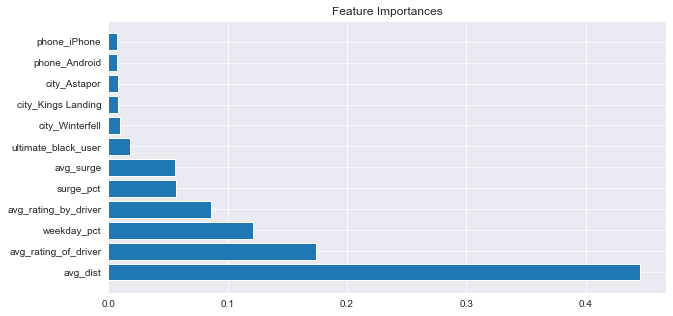

In [817]:
plt.figure(figsize=(10,5))
feat_imp = pd.DataFrame(rf_n.feature_importances_,index=X_mod.columns,
             columns=['Importance']).sort_values('Importance',ascending=False)
plt.barh(y=feat_imp.index,width=feat_imp['Importance'])
plt.title('Feature Importances');

In [818]:
#remove phone and city
df_new = df.drop(['city_Astapor','city_Kings Landing','city_Winterfell','phone_Android','phone_iPhone','ultimate_black_user'],axis=1) #city_Astapor','city_Kings Landing','city_Winterfell',
X_new = df_new.drop('retention',axis=1)

In [819]:
imputer.fit(X_new)
X_new[:] = imputer.transform(X_new)
X_new_scaled = scaler.fit_transform(X_new)
X_train_new,X_test_new, y_train,y_test=train_test_split(X_scaled,y,test_size=0.2, random_state=123)

In [820]:
rf_randS.fit(X_train_new,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]})

In [880]:
y_pred_new = rf_randS.predict(X_test_new)
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.44      0.24      0.31      2999
           1       0.72      0.87      0.79      6883

    accuracy                           0.68      9882
   macro avg       0.58      0.55      0.55      9882
weighted avg       0.64      0.68      0.64      9882



Text(1, 2.2, 'Actual')

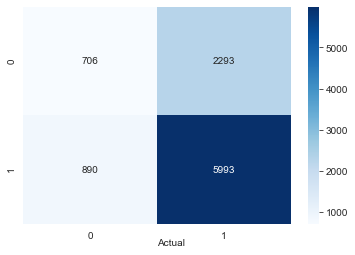

In [919]:
confusion_matrix(y_test,y_pred_new)
sns.heatmap(confusion_matrix(y_test,y_pred_new), annot=True,cmap='Blues',fmt='g')
plt.text(1, 2.2, 'Actual')

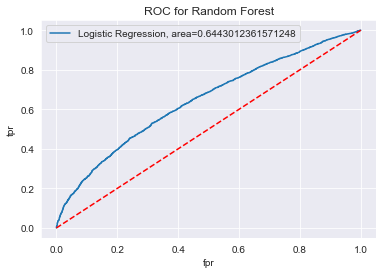

In [870]:
fpr,tpr,th = roc_curve(y_test,rf_randS.predict_proba(X_test_new)[:,1])
roc_rf = roc_auc_score(y_test,rf_randS.predict_proba(X_test_new)[:,1])
                       
plt.plot(fpr,tpr,label= 'Random Forest, area={}'.format(roc_rf))
plt.plot([0,1],[0,1],'r--')

              
plt.title('ROC for Ra`ndom Forest')
plt.xlabel('fpr')
plt.ylabel('tpr')  
plt.legend();
                                                                                                         
                                                                                                         

There is improvement in recall, the area under the curve is improved

## KNeighborsClassifier

In [837]:
#kneighborsClassifier
params= {'n_neighbors': range(1,12),
         'weights':['uniform','distance'],
         'metric':['eucledian','manhattan']}
knn = KNeighborsClassifier()

gs = GridSearchCV(knn,param_grid = params, verbose=1,n_jobs=-1,cv=3)
model_knn = gs.fit(X_train_new,y_train)
         

Fitting 3 folds for each of 44 candidates, totalling 132 fits


In [838]:
model_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

In [841]:
y_pred_knn = model_knn.predict(X_test_new)
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.45      0.25      0.32      2999
           1       0.73      0.87      0.79      6883

    accuracy                           0.68      9882
   macro avg       0.59      0.56      0.55      9882
weighted avg       0.64      0.68      0.65      9882



Text(1, 2.2, 'Actual')

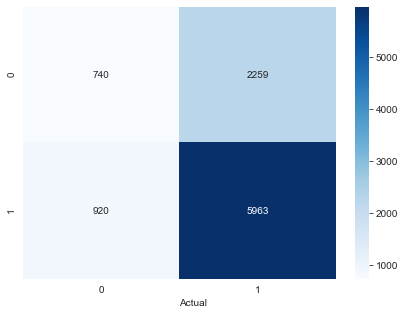

In [920]:
confusion_matrix(y_pred_knn,y_test)
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test,y_pred_knn), annot=True,cmap='Blues',fmt='g')
plt.text(1, 2.2, 'Actual')


In [917]:
920+5963

6883

In [915]:
(y_test==1).sum(),(y_test==0).sum()

(6883, 2999)

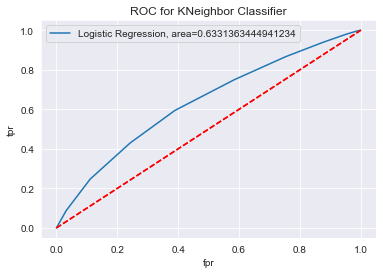

In [872]:
fpr,tpr,th = roc_curve(y_test,model_knn.predict_proba(X_test_new)[:,1])
plt.plot(fpr,tpr,label = 'Logistic Regression, area={}'.format(roc_auc_score(y_test,model_knn.predict_proba(X_test_new)[:,1])))
plt.plot([0,1],[0,1],'r--')

plt.plot([0,1],[0,1],'r--')

              
plt.title('ROC for KNeighbor Classifier')
plt.xlabel('fpr')
plt.ylabel('tpr')  
plt.legend();

In [883]:
740+2259

2999

In [884]:
920+5963

6883